In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tenseal cryptography numpy pillow torchvision pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import os

making directories to store different data

In [ ]:
os.makedirs("/content/drive/MyDrive/CBIR_AES_FHE/data", exist_ok=True)
os.makedirs("/content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_images", exist_ok=True)
os.makedirs("/content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_features", exist_ok=True)

json file creation for mapping the encrypted feature vectors to the aes encrypted images...

In [ ]:
import json
import os

# File path for the JSON file (make sure to include the file name)
json_file_path = "/content/drive/MyDrive/CBIR_AES_FHE/data/mapping.json"

# New data to append
new_mapping = {
    "encrypted_feature_vector_3": "encrypted_image_3.aes",
    "encrypted_feature_vector_4": "encrypted_image_4.aes"
}

# Check if the JSON file already exists
if os.path.exists(json_file_path):
    # Load existing data
    with open(json_file_path, "r") as json_file:
        mapping_data = json.load(json_file)
else:
    # Create an empty dictionary if file does not exist
    mapping_data = {}

# Update the mapping with new data
mapping_data.update(new_mapping)

# Save the updated data back to the JSON file
os.makedirs(os.path.dirname(json_file_path), exist_ok=True)

with open(json_file_path, "w") as json_file:
    json.dump(mapping_data, json_file, indent=4)
    print(f"Updated JSON mapping file saved at: {json_file_path}")

Updated JSON mapping file saved at: /content/drive/MyDrive/CBIR_AES_FHE/data/mapping.json


this is the context genaration function.. it creates a context files private and public that are required in encrypting the feature vector... so it is encrypted by the public key and decrypted by the private key.

In [ ]:
import tenseal as ts
import os

def generate_ckks_context(save_path_public, save_path_secret):
    """
    Generates and saves both public and secret CKKS contexts, including Galois keys.

    Args:
    - save_path_public (str): Path to save the public CKKS context (encryption only).
    - save_path_secret (str): Path to save the secret CKKS context (decryption).

    Returns:
    - None
    """
    try:
        # Create directories if they don't exist
        os.makedirs(os.path.dirname(save_path_public), exist_ok=True)
        os.makedirs(os.path.dirname(save_path_secret), exist_ok=True)

        # Create TenSEAL context for CKKS
        context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=8192,
            coeff_mod_bit_sizes=[60, 40, 60]
        )
        context.global_scale = 2**21

        # Generate Galois keys
        context.generate_galois_keys()

        # Verify private status before saving
        if context.is_private():
            print("The context is private before saving.")
        else:
            raise Exception("The context is unexpectedly public after creation.")

        # Save the full context (with secret key) for decryption purposes
        with open(save_path_secret, 'wb') as f:
            f.write(context.serialize(save_secret_key=True))  # Explicitly save the secret key
        print(f"Secret CKKS context saved at: {save_path_secret}")

        # Remove the secret key and save the public context for encryption purposes
        context.make_context_public()
        with open(save_path_public, 'wb') as f:
            f.write(context.serialize())
        print(f"Public CKKS context saved at: {save_path_public}")

    except Exception as e:
        print(f"Error generating CKKS contexts: {e}")

def verify_context_privacy(context_path):
    """
    Verifies if a CKKS context loaded from a file is private or public.
    """
    try:
        with open(context_path, "rb") as f:
            context = ts.context_from(f.read())

        if context.is_private():
            print(f"The context loaded from {context_path} is private and can decrypt.")
        else:
            print(f"The context loaded from {context_path} is public and cannot decrypt.")
    except Exception as e:
        print(f"Error verifying CKKS context: {e}")

# Generate CKKS contexts
save_path_public = "/content/drive/MyDrive/CBIR_AES_FHE/data/save_path_public.pkl"
save_path_secret = "/content/drive/MyDrive/CBIR_AES_FHE/data/save_path_secret.pkl"
generate_ckks_context(save_path_public, save_path_secret)

# Verify the secret and public contexts after saving
print("\nVerifying saved contexts...")
verify_context_privacy(save_path_secret)  # Should be private
verify_context_privacy(save_path_public)  # Should be public

The context is private before saving.
Secret CKKS context saved at: /content/drive/MyDrive/CBIR_AES_FHE/data/save_path_secret.pkl
Public CKKS context saved at: /content/drive/MyDrive/CBIR_AES_FHE/data/save_path_public.pkl

Verifying saved contexts...
The context loaded from /content/drive/MyDrive/CBIR_AES_FHE/data/save_path_secret.pkl is private and can decrypt.
The context loaded from /content/drive/MyDrive/CBIR_AES_FHE/data/save_path_public.pkl is public and cannot decrypt.


part 1: database creation, and more image adding/updation... user inputs all images he wants to save in the database... firstly their features are extracted, they are encrypted by a ckks scheme... then the image is encrypted my aes... both of them are linked in the json file created above (Cheon-Kim-Kim-Song encryption)

In [ ]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes
from PIL import Image
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import tenseal as ts
import os
import json

# File paths
ckks_public_context_path = "/content/drive/MyDrive/CBIR_AES_FHE/data/save_path_public.pkl"
json_file_path = "/content/drive/MyDrive/CBIR_AES_FHE/data/mapping.json"
encrypted_images_folder = "/content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_images"
encrypted_features_folder = "/content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_features"

# AES key (16 bytes for AES-128)
aes_key = b'SixteenByteKey!!'

# Ensure the mapping JSON file exists
if not os.path.exists(json_file_path):
    os.makedirs(os.path.dirname(json_file_path), exist_ok=True)
    with open(json_file_path, "w") as json_file:
        json.dump({}, json_file)

# Load CKKS context
def load_ckks_context(context_path):
    try:
        with open(context_path, 'rb') as f:
            context = ts.context_from(f.read())
        return context
    except Exception as e:
        print(f"Error loading CKKS context: {e}")
        return None

# Preprocess image for feature extraction
def preprocess_image_for_feature_extraction(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image.unsqueeze(0)

# Extract features using ResNet
def extract_features(model, preprocessed_image):
    with torch.no_grad():
        features = model(preprocessed_image)
    return features.squeeze().numpy().flatten()

# CKKS Encrypt feature vector
def ckks_encrypt_feature_vector(feature_vector, public_context):
    try:
        return ts.ckks_vector(public_context, feature_vector.tolist())
    except Exception as e:
        print(f"Error encrypting feature vector: {e}")
        return None

# Updated AES Encrypt the image
def aes_encrypt_image(image_path, key):
    try:
        # Read the image
        with open(image_path, 'rb') as f:
            image_data = f.read()

        # Generate a random IV (Initialization Vector)
        iv = get_random_bytes(AES.block_size)

        # Create AES cipher object
        cipher = AES.new(key, AES.MODE_CBC, iv)

        # Pad the image data to ensure it's a multiple of block size
        padded_data = pad(image_data, AES.block_size)

        # Encrypt the image data
        encrypted_data = cipher.encrypt(padded_data)

        # Store the encrypted image data with the IV prepended
        encrypted_image = iv + encrypted_data

        return encrypted_image

    except Exception as e:
        print(f"Error during AES encryption: {e}")
        return None

# Main encryption process
public_context = load_ckks_context(ckks_public_context_path)
if not public_context:
    print("Failed to load CKKS public context.")
    exit()

# Upload images
from google.colab import files
uploaded = files.upload()

model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove classification layer
model.eval()

for filename in uploaded.keys():
    image_path = filename
    preprocessed_image = preprocess_image_for_feature_extraction(image_path)

    if preprocessed_image is not None:
        # Extract and encrypt features
        feature_vector = extract_features(model, preprocessed_image)
        encrypted_vector = ckks_encrypt_feature_vector(feature_vector, public_context)

        if encrypted_vector:
            encrypted_feature_path = os.path.join(encrypted_features_folder, f"encrypted_feature_{filename.split('.')[0]}.pkl")
            with open(encrypted_feature_path, 'wb') as f:
                f.write(encrypted_vector.serialize())
            print(f"Encrypted feature vector saved at: {encrypted_feature_path}")

        # AES Encrypt the image
        encrypted_image = aes_encrypt_image(image_path, aes_key)
        if encrypted_image:
            # Retain original file extension
            file_name, file_extension = os.path.splitext(filename)
            encrypted_image_path = os.path.join(encrypted_images_folder, f"{file_name}_encrypted{file_extension}")
            with open(encrypted_image_path, 'wb') as f:
                f.write(encrypted_image)
            print(f"Encrypted image saved at: {encrypted_image_path}")

            # Update JSON mapping
            with open(json_file_path, "r") as json_file:
                mapping_data = json.load(json_file)

            mapping_data[encrypted_feature_path] = encrypted_image_path

            with open(json_file_path, "w") as json_file:
                json.dump(mapping_data, json_file, indent=4)

            print(f"Mapping updated: {encrypted_feature_path} -> {encrypted_image_path}")
        else:
            print(f"Skipping AES encryption for {filename} due to an error.")


Saving mini.jfif to mini.jfif
Saving PICT0116.JPG to PICT0116.JPG
Saving PICT0290.JPG to PICT0290.JPG
Saving pistaa.jfif to pistaa.jfif
Saving pistaa2.jfif to pistaa2.jfif
Saving tree.jpeg to tree.jpeg


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


Encrypted feature vector saved at: /content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_features/encrypted_feature_mini.pkl
Encrypted image saved at: /content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_images/mini_encrypted.jfif
Mapping updated: /content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_features/encrypted_feature_mini.pkl -> /content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_images/mini_encrypted.jfif
Encrypted feature vector saved at: /content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_features/encrypted_feature_PICT0116.pkl
Encrypted image saved at: /content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_images/PICT0116_encrypted.JPG
Mapping updated: /content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_features/encrypted_feature_PICT0116.pkl -> /content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_images/PICT0116_encrypted.JPG
Encrypted feature vector saved at: /content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_features/encrypted_feature_PICT0290.pkl
Encrypted image saved at: /content/dri

part 2: the user will enter the image, of which similar images the user wants to retrieve.... the features of the image will be extrcated, and ckks encrypted... then this vector will be compared to all other vectors in the folder using cosine similarity.. if similarity >80, the vectors will be chosen, their respective aes image would be mapped thru the json file, and it would be decrytped and then returned to the user....




Saving pistaa.jfif to pistaa (2).jfif
Decrypting AES image for encrypted_feature_pistaa.pkl...


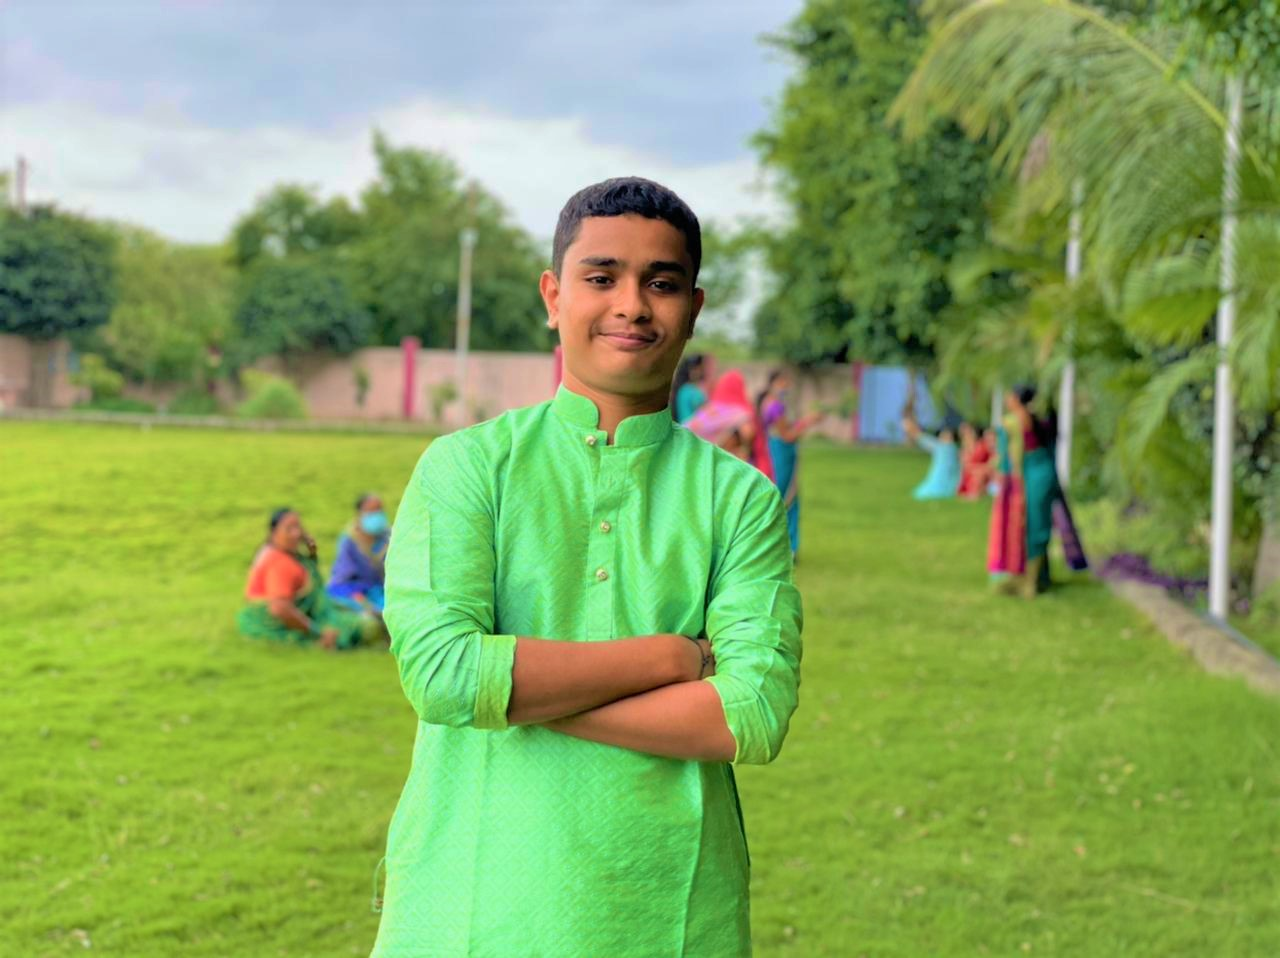

Decrypted image saved at: /content/drive/MyDrive/CBIR_AES_FHE/data/decrypted_images/decrypted_pistaa_encrypted.jfif.png
Decrypting AES image for encrypted_feature_pistaa2.pkl...


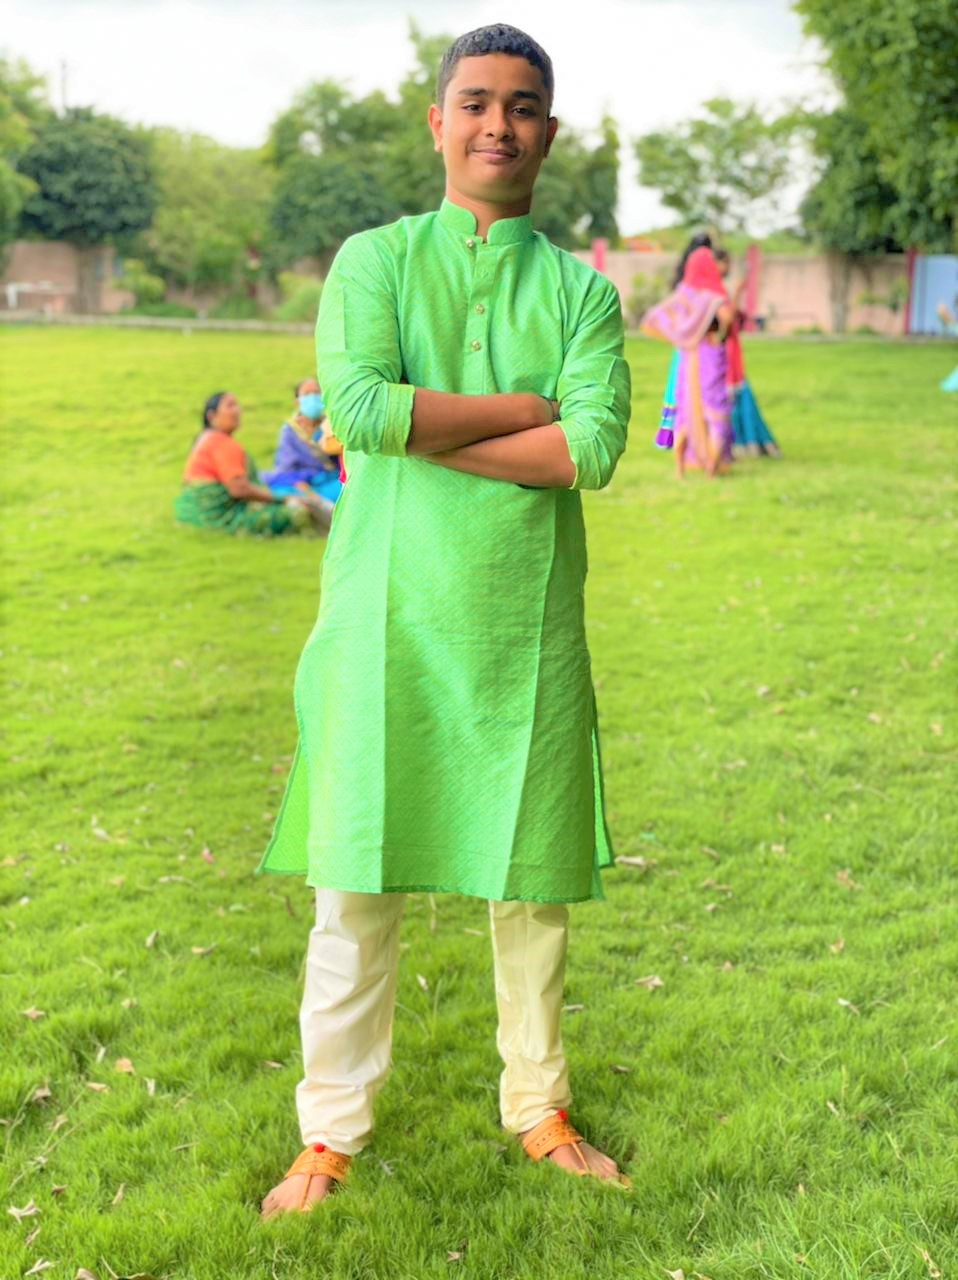

Decrypted image saved at: /content/drive/MyDrive/CBIR_AES_FHE/data/decrypted_images/decrypted_pistaa2_encrypted.jfif.png
Similar vectors for pistaa (2).jfif:
  encrypted_feature_pistaa.pkl: 100.00%
  encrypted_feature_pistaa2.pkl: 90.45%


In [ ]:
from PIL import Image
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import tenseal as ts
import os
import json
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad
import io

# Paths
ckks_secret_context_path = "/content/drive/MyDrive/CBIR_AES_FHE/data/save_path_secret.pkl"
encrypted_features_folder = "/content/drive/MyDrive/CBIR_AES_FHE/data/encrypted_features"
json_file_path = "/content/drive/MyDrive/CBIR_AES_FHE/data/mapping.json"
decrypted_images_folder = "/content/drive/MyDrive/CBIR_AES_FHE/data/decrypted_images"

# AES key (must match encryption key used earlier)
aes_key = b'SixteenByteKey!!'

# Create folder for decrypted images if it doesn't exist
os.makedirs(decrypted_images_folder, exist_ok=True)

# Load CKKS secret context
def load_ckks_context(context_path):
    try:
        with open(context_path, 'rb') as f:
            context = ts.context_from(f.read())
        return context
    except Exception as e:
        print(f"Error loading CKKS context: {e}")
        return None

# Preprocess image for ResNet input
def preprocess_image_for_feature_extraction(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image.unsqueeze(0)

# Extract features using ResNet
def extract_features(model, preprocessed_image):
    with torch.no_grad():
        features = model(preprocessed_image)
    return features.squeeze().numpy().flatten()  # Ensure 1D vector

# CKKS Encrypt feature vector
def ckks_encrypt_feature_vector(feature_vector, secret_context):
    try:
        return ts.ckks_vector(secret_context, feature_vector.tolist())
    except Exception as e:
        print(f"Error encrypting feature vector: {e}")
        return None

# Compute cosine similarity between two decrypted vectors
def compute_cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    if norm1 == 0 or norm2 == 0:
        return 0  # Handle zero magnitude vector case
    return dot_product / (norm1 * norm2)

from IPython.display import display

def aes_decrypt_image(encrypted_image_path, key, output_folder):
    try:
        # Read the encrypted image
        with open(encrypted_image_path, 'rb') as f:
            encrypted_data = f.read()

        # Extract the IV from the first 16 bytes
        iv = encrypted_data[:16]
        encrypted_data = encrypted_data[16:]  # Rest is the actual encrypted data

        # Create AES cipher object with the same key and IV
        cipher = AES.new(key, AES.MODE_CBC, iv)

        # Decrypt the data
        decrypted_data = unpad(cipher.decrypt(encrypted_data), AES.block_size)

        # Save to a BytesIO object to emulate a file
        image_stream = io.BytesIO(decrypted_data)

        # Attempt to open as an image
        img = Image.open(image_stream)

        # Display the image inline in Colab
        display(img)  # Display the decrypted image in Colab

        # Save the decrypted image
        decrypted_image_path = os.path.join(output_folder, f"decrypted_{os.path.basename(encrypted_image_path)}.png")
        img.save(decrypted_image_path)
        return decrypted_image_path

    except Exception as e:
        print(f"Error during decryption: {e}")
        return None


# Compare encrypted feature vectors and decrypt similar ones
def compare_and_decrypt(query_vector, secret_context):
    similar_vectors = []
    if not os.path.exists(json_file_path):
        print(f"Mapping file not found at {json_file_path}")
        return similar_vectors

    # Load mapping
    with open(json_file_path, "r") as json_file:
        mapping_data = json.load(json_file)

    for file_name in os.listdir(encrypted_features_folder):
        if file_name.endswith(".pkl"):
            encrypted_vector_path = os.path.join(encrypted_features_folder, file_name)
            with open(encrypted_vector_path, "rb") as f:
                encrypted_vector = ts.ckks_vector_from(secret_context, f.read())

            # Decrypt both vectors
            decrypted_query_vector = query_vector.decrypt()
            decrypted_stored_vector = encrypted_vector.decrypt()

            # Compute similarity
            similarity = compute_cosine_similarity(decrypted_query_vector, decrypted_stored_vector) * 100
            if similarity > 80:
                similar_vectors.append((file_name, similarity))
                aes_encrypted_image_path = mapping_data.get(encrypted_vector_path)
                if aes_encrypted_image_path:
                    print(f"Decrypting AES image for {file_name}...")
                    decrypted_image_path = aes_decrypt_image(aes_encrypted_image_path, aes_key, decrypted_images_folder)
                    if decrypted_image_path:
                        print(f"Decrypted image saved at: {decrypted_image_path}")
    return similar_vectors

# Main process
def main():
    # Load CKKS secret context
    secret_context = load_ckks_context(ckks_secret_context_path)
    if not secret_context:
        print("Failed to load CKKS secret context.")
        return

    # Load ResNet model
    model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
    model.eval()

    # Upload image
    from google.colab import files
    uploaded = files.upload()

    for filename in uploaded.keys():
        image_path = filename

        # Preprocess and extract features
        try:
            preprocessed_image = preprocess_image_for_feature_extraction(image_path)
            feature_vector = extract_features(model, preprocessed_image)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue

        # Encrypt the feature vector
        query_encrypted_vector = ckks_encrypt_feature_vector(feature_vector, secret_context)
        if query_encrypted_vector is None:
            print(f"Failed to encrypt feature vector for {image_path}.")
            continue

        # Compare with existing vectors and decrypt similar ones
        try:
            similar_vectors = compare_and_decrypt(query_encrypted_vector, secret_context)
            if similar_vectors:
                print(f"Similar vectors for {image_path}:")
                for vector_name, similarity in similar_vectors:
                    print(f"  {vector_name}: {similarity:.2f}%")
            else:
                print(f"No similar vectors found for {image_path}.")
        except Exception as e:
            print(f"Error finding similar vectors for {image_path}: {e}")

if __name__ == "__main__":
    main()

this is just if we have to clear the folders...

In [ ]:
import shutil

# Path to the folder
folder_path = "/content/drive/MyDrive/CBIR_AES_FHE/scripts"

# Delete all contents of the folder
shutil.rmtree(folder_path)  # Deletes the folder and all its contents
os.makedirs(folder_path, exist_ok=True)  # Recreates the folder if needed
print(f"All contents of the folder '{folder_path}' have been deleted.")

All contents of the folder '/content/drive/MyDrive/CBIR_AES_FHE/scripts' have been deleted.
